In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from selenium import webdriver
import time
from folium.plugins import HeatMap


## Import data

In [2]:
df = pd.read_csv('data/DataAnalyst.csv', index_col="Unnamed: 0")

## Filter numbers

In [3]:
df['temp'] = df['Salary Estimate'].str.findall('\$.+?K')
df['temp'] = df['temp'].astype('str')
df['Salary Lower Range'] = df['temp'].apply(lambda x: x.split(' ')[0])
df['Salary Higher Range'] = df['temp'].apply(lambda x: x.split(' ')[-1])
df.drop(columns =["temp","Salary Estimate"], inplace = True) 

## Clean and modify columns

In [4]:
df['Salary Lower Range'] = df['Salary Lower Range'].str.extract('(\d+)', expand=False)
df['Salary Higher Range'] = df['Salary Higher Range'].str.extract('(\d+)', expand=False)
df['Rating'] = df['Rating'].astype('float')
df['Company Name'] = df['Company Name'].astype('str')
df['Job Description'] = df['Job Description'].astype('str')
df['Company Name'] = df['Company Name'].apply(lambda x: re.sub('\\n.+','',x))
df['Job Description'] = df['Job Description'].apply(lambda x: re.sub('\\n',' ',x))
df['Remote'] = df['Job Description'].apply(lambda x: 'yes' if 'remote' in x else 'no')
df.fillna('Unknown')
df['Salary Lower Range'] = df['Salary Lower Range'].astype('float')
df['Salary Higher Range'] = df['Salary Higher Range'].astype('float')
df['Salary Lower Range'] = 1000*df['Salary Lower Range']
df['Salary Higher Range'] = 1000*df['Salary Higher Range']
df["Job Title"] = df["Job Title"].str.lower()
df['Seniority'] = df['Job Title'].apply(lambda x: 'senior' if ('senior'or'sr') in x 
                                        else ('junior' if ('junior'or'jr') in x 
                                              else 'data analyst'))
junior_rem = df.get((df.Remote == 'yes') &(df.Seniority =='junior'))
df.Rating = df.Rating.replace([-1,-1.0,'-1','-1.0'],0.0)
df = df.replace([-1,-1.0,'-1','-1.0'],'Unknown')

## Data visualization

### 1. Percentages of jobs that are junior or remote and a golden ticket

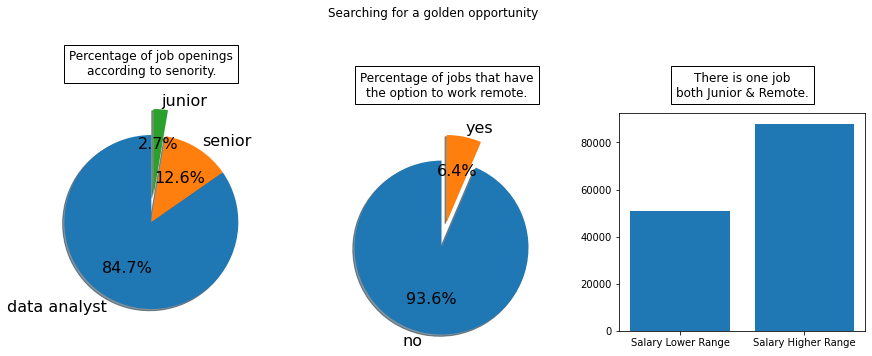

In [5]:
fig, axs = plt.subplots(1,3, figsize=(15,4))
fig.suptitle('Searching for a golden opportunity', y= 1.25)

# fig 1
sen_labels = list(df.Seniority.value_counts().keys())
sen_sizes = list(df.Seniority.value_counts().values)
axs[0].pie(sen_sizes, explode=(0,0,0.3), labels=sen_labels,
           autopct='%1.1f%%',shadow=True, startangle=90, textprops={'fontsize': 16})
axs[0].set_title("Percentage of job openings\naccording to senority.", bbox={'facecolor':'1', 'pad':5},y=1.15)

# fig 2
rem_labels = list(df.Remote.value_counts().keys())
rem_sizes = list(df.Remote.value_counts().values)
axs[1].pie(rem_sizes, explode=(0.3, 0), labels=rem_labels,
           autopct='%1.1f%%',shadow=True, startangle=90, textprops={'fontsize': 16})
axs[1].set_title("Percentage of jobs that have\nthe option to work remote.", bbox={'facecolor':'1', 'pad':5},y=1.05)

# fig 3
sals = ['Salary Lower Range', 'Salary Higher Range']
rangs = [int(junior_rem['Salary Lower Range'].values), int(junior_rem['Salary Higher Range'].values)]
axs[2].bar(sals,rangs)
axs[2].set_title("There is one job\nboth Junior & Remote.", bbox={'facecolor':'1', 'pad':5},y=1.05)

plt.show()

# 
  
   

### 2. Industry sector better ranked for Data Analysts

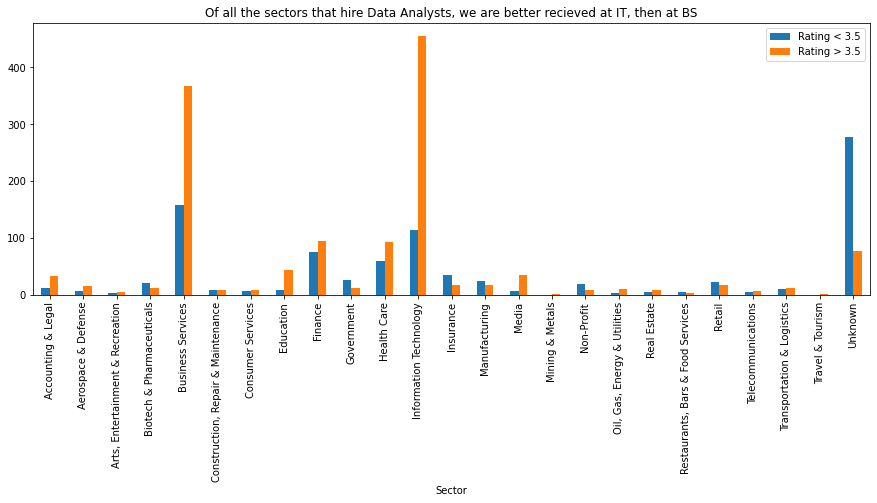

In [6]:
new_tab = pd.crosstab(df.Sector,df.Rating >= 3.5)
new_tab.plot.bar(figsize=(15,5),title="Of all the sectors that hire Data Analysts, we are better recieved at IT, then at BS")
plt.legend(['Rating < 3.5','Rating > 3.5'], loc='best')
plt.show()

# 

## 3. Best paid jobs

Top 5 values sorted by (Salary Higher Range, mean) in descending order

c:\users\dxoco\appdata\local\programs\python\python37-32\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


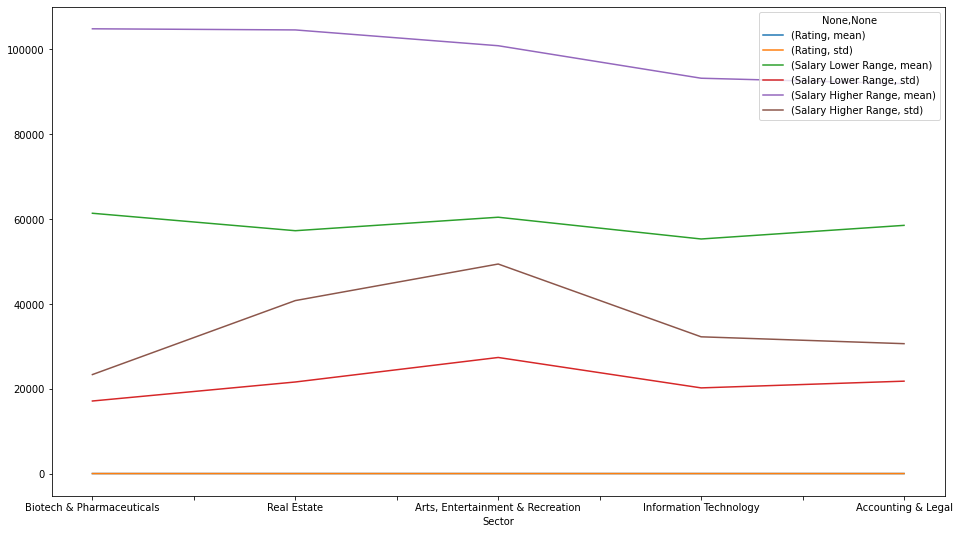

Rating           Salary Lower Range  \
                                      mean       std               mean   
Sector                                                                    
Biotech & Pharmaceuticals         3.390909  0.602787       61363.636364   
Real Estate                       3.458333  1.161080       57250.000000   
Arts, Entertainment & Recreation  3.800000  0.877496       60428.571429   
Information Technology            3.893509  0.879213       55298.245614   
Accounting & Legal                3.741860  0.441983       58511.627907   

                                               Salary Higher Range  \
                                           std                mean   
Sector                                                               
Biotech & Pharmaceuticals         17105.953243       104848.484848   
Real Estate                       21587.559549       104583.333333   
Arts, Entertainment & Recreation  27366.994372       100857.142857   
Information Technology            20197.239116        93196.491228   
Accounting & Legal                21781.788038        91930.232558   

                                                
                                           std  
Sector                                          
Biotech & Pharmaceuticals         23336.025278  
Real Estate                       40777.574794  
Arts, Entertainment & Recreation  49397.802149  
Information Technology            32236.766688  
Accounting & Legal                30620.873171

In [7]:
lewhy = df.groupby(['Sector']).agg(['mean','std'])
lewhy.sort_values(('Salary Higher Range','mean'),ascending=False)[:5].plot(figsize=(16,9))
plt.show()
lewhy.sort_values(('Salary Higher Range','mean'),ascending=False)[:5]

## 4. Heatmap for offices concentrations

In [12]:
places = list(df.Location.unique())
for p in range(len(places)):
    places[p] = places[p].replace(' ','+')

In [13]:
dirty_coord = []
url = 'https://www.google.com/maps/place/'
browser = webdriver.Edge()
browser.maximize_window
time.sleep(5)
for p in places:
    browser.get(url+p)
    time.sleep(5)
    currentURL = browser.current_url
    if len(currentURL) == len(url+p):
        browser.get(url+p)
        time.sleep(10)
        currentURL = browser.current_url
    else:
        dirty_coord.append(currentURL)

In [14]:
lon=[]
lat=[]
cleaner_coord=[]
for d in range(len(dirty_coord)):
    a = re.findall('!3d.+',dirty_coord[d])
    cleaner_coord.append(str(a).split('!'))
time.sleep(3)
for i in range(len(cleaner_coord)):
    try:
        lon.append(cleaner_coord[i][-2][2:])
        lat.append(cleaner_coord[i][-1][2:-2])
    except:
        lon.append(cleaner_coord[i-1][-2][2:])
        lat.append(cleaner_coord[i-1][-1][2:-2])

In [19]:
coso = df.Location.value_counts().values
coso = coso.astype('object')
hmap = folium.Map(location=[41, -93], zoom_start=4, )
hm_wide = HeatMap(list(zip(lon, lat, coso)),
                   min_opacity=0.2,
                   max_val=500,
                   radius=17, blur=15, 
                   max_zoom=1,)
hmap.add_child(hm_wide)
# https://alcidanalytics.com/p/geographic-heatmap-in-python